In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
from __future__ import division

%load_ext autoreload
%autoreload 2

if 1: # common
    import numpy as np
    import copy
    import cv2
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D  # THIS MUST BE IMPORTED!
    import open3d
    import time 
    # import pcl

if 1: # my lib
    import sys
    import os
    # ROOT = os.path.dirname(os.path.abspath(__file__))+"/../../
    ROOT = "/home/feiyu/catkin_ws/src/simon_says/"
    sys.path.append(ROOT)
    from utils.lib_cloud import read_color_and_depth_image, rgbd2cloud, getCloudContents, formNewCloud, filtCloudByRange
    from utils.lib_ransac import ransac
    from utils.lib_plane import fit_plane_by_PCA, abc_to_w, create_plane, PlaneModel
    from utils.lib_plot import show, plot_cloud_3d
    
    import utils.lib_geo_trans as lib_geo_trans
    

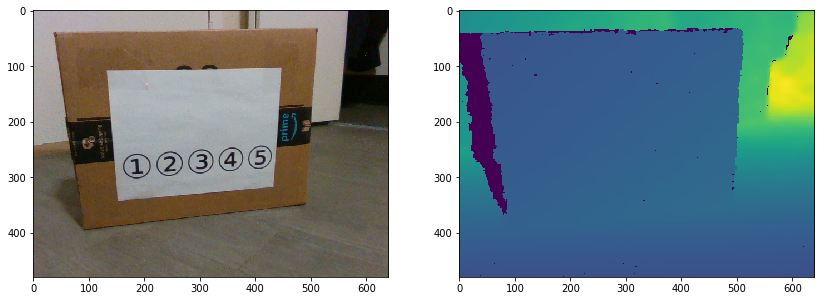

In [2]:
# Read color and depth image
images_folder = ROOT + "data/plane_detection/"
ith_image=1
color_img, depth_img = read_color_and_depth_image(images_folder, ith_image,
    output_img_format="cv2", index_len=1,
    image_folder="./", image_name="image_",
    depth_doler="./", depth_name="depth_",
)

# Plot
show((color_img, depth_img), figsize=(14, 5))

In [3]:
# camera info
FILNAME_CAMERA_INFO = ROOT + "config/cam_params_realsense.json"
camera_intrinsic = open3d.io.read_pinhole_camera_intrinsic(FILNAME_CAMERA_INFO)
print(camera_intrinsic.intrinsic_matrix)

# Get point cloud from rgbd image
cloud = rgbd2cloud(color_img, depth_img, camera_intrinsic, input_img_format="cv2")

# Filtering
cloud = open3d.geometry.voxel_down_sample(cloud, voxel_size=0.005)
cloud = filtCloudByRange(cloud, zmax=1.0, ymax=0.1)

[[617.25         0.         317.39212036]
 [  0.         617.54864502 245.98019409]
 [  0.           0.           1.        ]]


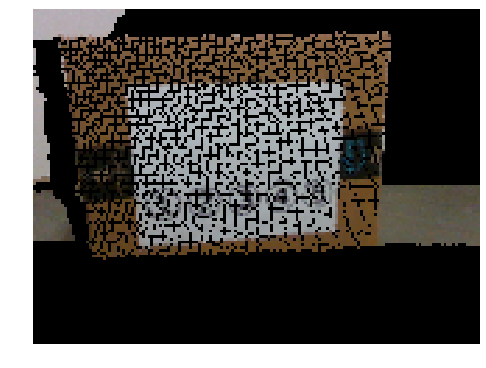

In [4]:
# Draw whole cloud
xyz, color = getCloudContents(cloud) # color: rgb
if 0: # 3d cloud by open3d
    open3d.draw_geometries([cloud])
if 0: # 3d cloud by plt
    fig = plt.figure(figsize=(8, 8)).gca(projection='3d')
    fig.scatter(xs=xyz[:, 0], ys=xyz[:, 1], zs=xyz[:, 2]); plt.xlabel('x'); plt.ylabel('y');
if 1: # 2d projected image
    plot_cloud_3d(xyz, color=color, figsize=(8, 8), X=0, Y=0, Z=0, w=640, h=480,
                 camera_intrinsics=camera_intrinsic.intrinsic_matrix,
                 point_scale=4.0)


--------------------------------
Start RANSAC algorithm ...
Input: num points = 10868, features dim = 3
Config: n_pts_base = 3, n_pts_extra = 20, dist_thre = 0.01


Time cost for RANSAC = 0.112 seconds
--------------------------------

source points = 10868, inliers points = 6474


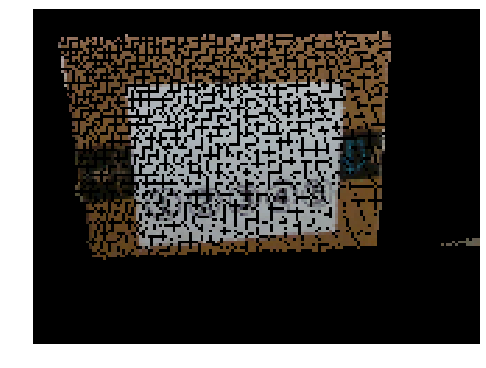

In [5]:
# segment plane by l ransac
model = PlaneModel(feature_dimension=3)
coefs, inliers = ransac(
    xyz,
    model, 
    n_pts_base=3,
    n_pts_extra=20,
    max_iter=20,
    dist_thre=0.01,
    print_time=True,
    debug=False,
)
print("source points = {}, inliers points = {}".format(xyz.shape[0], inliers.size ))

# Get inlier points
plane_xyz = xyz[inliers, :]
plane_color = color[inliers, :]

# Draw plane
if 0: # by Open3D
    plane_open3d_cloud = formNewCloud(plane_xyz, plane_color)
    open3d.draw_geometries([plane_open3d_cloud])


if 1: # 2d projected image
    plot_cloud_3d(plane_xyz, color=plane_color, 
                  figsize=(8, 8), X=0, Y=0, Z=0, w=640, h=480,
                  camera_intrinsics=camera_intrinsic.intrinsic_matrix,
                  point_scale=4.0)

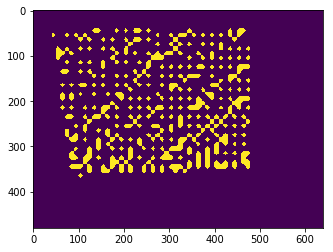

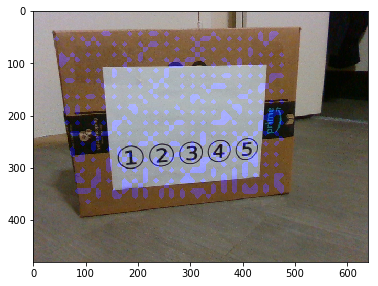

[-0.0095315  -0.03240055  0.56136453] [ 0.2248815   0.28164859 -0.93279279]


In [93]:
# Get plane center, plane normal, and mask image of inliers
cloud_plane = formNewCloud(plane_xyz, plane_color)
cloud_plane = open3d.geometry.voxel_down_sample(cloud_plane, voxel_size=0.02)
xyz, color = getCloudContents(cloud_plane)

# Project points and get mask
mask, vu_s = lib_geo_trans.project_points_to_image_mask(xyz, camera_intrinsic, scale=10.0)
plt.imshow(mask)
plt.show()

def increase_color(img, mask, color):
    '''
    img: 3 channels, uint8
    mask: 1 channel, same size as img, bool
    color: a list of 3 values
    '''
    img = img.astype(np.int32)
    for i in range(3):
        imgi = img[:, :, i]
        imgi[mask] += color[i]
    img[img>255] = 255
    img[img<0] = 0
    img = img.astype(np.uint8)
    return img

# draw mask onto image
img_disp = color_img.copy()
img_disp = increase_color(color_img, mask, [100,0,0])

#show((img_disp[:, :, 0]))
show((img_disp))

# Get plane params
p_cent = np.median(xyz, axis=0) 
v_norm = coefs[1:]
if v_norm[2] > 0:
    v_norm = -v_norm
print(p_cent, v_norm)

In [77]:
camera_intrinsics = camera_intrinsic
camera_intrinsics.intrinsic_matrix

array([[617.25      ,   0.        , 317.39212036],
       [  0.        , 617.54864502, 245.98019409],
       [  0.        ,   0.        ,   1.        ]])

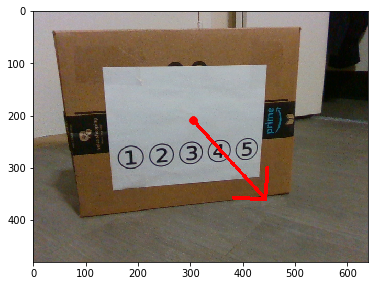

In [105]:
# Draw plane center and norm
def _draw_plane_norm(p_cent, v_norm, img_disp):

    # Draw plane center
    p0_xy = lib_geo_trans.cam2pixel(
        p_cent.reshape((-1, 1)), camera_intrinsics.intrinsic_matrix)
    p0_xy = (int(p0_xy[0]), int(p0_xy[1]))
    cv2.circle(img_disp, p0_xy, radius=5, color=[0,0,255], 
               thickness=5, lineType=cv2.LINE_AA)

    # Draw plane norm
    len_arrow = 0.3
    p1 = p_cent + len_arrow * v_norm
    p1_xy = lib_geo_trans.cam2pixel(
        p1.reshape((-1, 1)), camera_intrinsics.intrinsic_matrix)
    p1_xy = (int(p1_xy[0]), int(p1_xy[1]))
    cv2.arrowedLine(img_disp, p0_xy, p1_xy, color=[0,0,255], thickness=5, tipLength=0.3)
    
    return img_disp

img_disp = color_img.copy()
img_disp = _draw_plane_norm(p_cent, v_norm, img_disp)
show((img_disp))

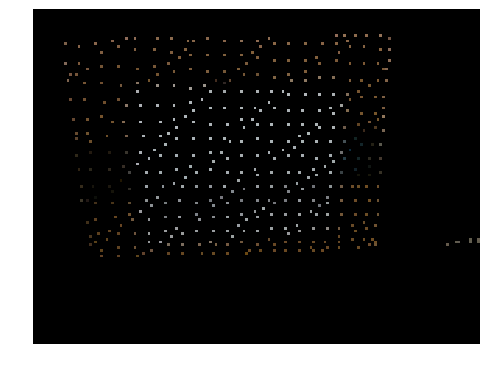

In [78]:
if 1: # 2d projected image
    plot_cloud_3d(xyz, color=color, 
                  figsize=(8, 8), X=0, Y=0, Z=0, w=640, h=480,
                  camera_intrinsics=camera_intrinsics.intrinsic_matrix,
                  point_scale=4.0)

In [10]:
xyz

array([[-0.17191346,  0.05519885,  0.55000001],
       [ 0.07210072, -0.00349115,  0.59122224],
       [ 0.13561423, -0.11980199,  0.56972   ],
       ...,
       [ 0.00305203,  0.00741554,  0.57739709],
       [-0.07568641, -0.15144034,  0.51393063],
       [ 0.12182869,  0.08116405,  0.6295799 ]])

[ 0.2248815   0.28164859 -0.93279279]


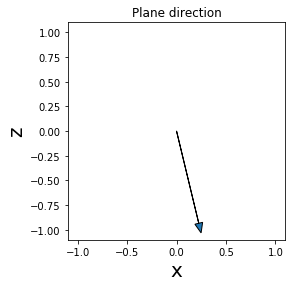

In [11]:
normal = coefs[1:]
print(normal)

# plot normal direction in the car's coordinate
xn, yn, zn = normal
# plt.plot([0, xn], [0, zn], 'r')
plt.arrow(0,0,xn,zn,head_width=0.08, head_length=0.1)
plt.xlim((-1.1, 1.1))
plt.ylim((-1.1, 1.1))
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Plane direction')
plt.xlabel('x', fontsize=20)
plt.ylabel('z', fontsize=20)
plt.show()